In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

## Language dataset

In [22]:
class LanguageDataset(Dataset):
    '''
    Args:
    - min_length (int):  minimum length of the generated sequences
    - max_length (int):  maximum length of the generated sequences
    - p (float):         probability of generating a valid sequence
    - num_samples (int): number of samples to generate
    
    Returns:
    list of tuples (sequence, label) where sequence is a one-hot encoded tensor and label is 0 or 1.
    '''
    def __init__(self, min_length, max_length, p, num_samples):
        self.min_length = min_length
        self.max_length = max_length
        self.p = p
        self.num_samples = num_samples
        self.samples = self.generate_samples()
        self.avg_len = self.average_length(self.samples)
    
    def generate_samples(self):
        samples = []
        for _ in range(self.num_samples):
            length = np.random.randint(self.min_length, self.max_length + 1)
            if np.random.rand() < self.p:
                n = length // 3
                sequence = 'a' * n + 'b' * n + 'c' * n
            else:
                # Generate an invalid sequence
                sequence = self.generate_invalid_sequence(length)
            samples.append((sequence, int(self.is_language(sequence))))
        samples_no_duplicates = list(set(samples)) # remove duplicates

        return samples_no_duplicates
    
    def generate_invalid_sequence(self, length):
        sequence = ''.join(np.random.choice(['a', 'b', 'c'], size=length))
        while self.is_language(sequence):
            sequence = ''.join(np.random.choice(['a', 'b', 'c'], size=length))
        return sequence
    
    def is_language(self, sequence):
        counts = {'a': 0, 'b': 0, 'c': 0}
        for char in sequence:
            counts[char] += 1
        return counts['a'] == counts['b'] == counts['c']

    def average_length(self, samples):
        return np.mean([len(sequence) for sequence, _ in self.samples])
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sequence, label = self.samples[idx]
        indices = torch.tensor([ord(c) - ord('a') for c in sequence], dtype=torch.long)
        one_hot_sequence = torch.nn.functional.one_hot(indices, num_classes=3).float()
        return one_hot_sequence, torch.tensor(label)

def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    labels = torch.stack(labels)
    return sequences_padded, labels


def generate_data(min_length, max_length, p, num_samples, batch_size=32):
    dataset = LanguageDataset(min_length, max_length, p, num_samples)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    return data_loader

## Model definition

In [23]:
class LSTM(nn.Module):
    '''
    Args:
    - input_size (int):     The number of input features per time step (e.g., 3 for 'a', 'b', 'c')
    - hidden_size (int):    The number of features in the hidden state of the LSTM
    - output_size (int):    The number of output classes (e.g., 2 for binary classification)
    - n_layers (int):       The number of recurrent layers in the LSTM
    
    Returns:
    The predicted output after passing through the LSTM model.
    '''
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(input.size(0))
        output, (hidden, cell) = self.lstm(input, hidden)
        output = self.fc(output[:, -1, :])  # Use the output of the last time step
        output = self.softmax(output)
        return output

    def init_hidden(self, batch_size):
        return (torch.zeros(self.n_layers, batch_size, self.hidden_size),
                torch.zeros(self.n_layers, batch_size, self.hidden_size))

## Training and evaluation functions

In [24]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    '''
    Args:
    - model (nn.Module):         The model to train
    - train_loader (DataLoader): The DataLoader for the training data
    - val_loader (DataLoader):   The DataLoader for the validation data
    - criterion (nn.Module):     The loss function
    - optimizer (torch.optim):   The optimizer
    - num_epochs (int):          The number of epochs to train
    
    Returns:
    The best model found during training with the corresponding best validation accuracy obtained.
    '''
    best_val_acc = 0
    best_model = None
    for epoch in range(num_epochs):
        model.train()
        for sequences, labels in train_loader:
            optimizer.zero_grad()
            hidden = model.init_hidden(sequences.size(0))
            outputs = model(sequences, hidden)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for sequences, labels in val_loader:
                hidden = model.init_hidden(sequences.size(0))
                outputs = model(sequences, hidden)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = correct / total
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model
    return best_model, best_val_acc

In [25]:
def eval_model(model, data_loader, criterion='accuracy'):
    '''
    Args:
    - model (nn.Module):        The trained model
    - data_loader (DataLoader): The DataLoader for the evaluation data
    - criterion (str):          The evaluation criterion ('accuracy' or 'f1')

    Returns:
    The evaluation score (accuracy or F1) of the model on the evaluation data.
    '''
    model.eval()  # Set model to eval mode
    true_labels = []
    pred_labels = []

    with torch.no_grad():  # Deactivate gradients for the following code
        for batch in data_loader:  # Iterate over batches
            sequences, labels = batch  # Unpack the batch
            hidden = model.init_hidden(sequences.size(0))
            outputs = model(sequences, hidden)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    if criterion == 'accuracy':
        return accuracy_score(true_labels, pred_labels)
    elif criterion == 'f1':
        return f1_score(true_labels, pred_labels)
    else:
        raise ValueError("Invalid criterion. Choose 'accuracy' or 'f1'.")

### Generate data

In [26]:
# After generating the data loader, split it into train and validation sets
train_data_loader = generate_data(1, 20, 0.5, 1000, 32)

train_size = int(0.7 * len(train_data_loader.dataset))
train_data, val_data = random_split(train_data_loader.dataset, [train_size, len(train_data_loader.dataset) - train_size])

test_data = generate_data(21, 100, 0.5, 1000, 32).dataset

# Create separate data loaders for train, validation, and test sets
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [27]:
labels = [label for _, label in train_loader.dataset]
class_counts = np.bincount(labels)
class_weights = 1.0 / class_counts

weights = [class_weights[label] for label in labels]
weights = torch.tensor(weights, dtype=torch.float)
sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))

In [28]:
#train_loader = DataLoader(train_data, batch_size=32, sampler=sampler, collate_fn=collate_fn)

## Hyperparameter tuning

In [29]:
input_size = 3  # 'a', 'b', 'c'
output_size = 2  # 0 or 1
hidden_sizes = [16, 32, 64]
learning_rates = [0.001, 0.01, 0.1]

best_val_acc = 0
best_model = None

for hidden_size in hidden_sizes:
    for lr in learning_rates:
        model = LSTM(input_size, hidden_size, output_size)
        criterion = nn.CrossEntropyLoss()
        #criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))
        optimizer = optim.Adam(model.parameters(), lr=lr)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        model, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model

print(f'Best validation accuracy: {np.round(best_val_acc,3)}')
print (best_model)

Best validation accuracy: 0.985
LSTM(
  (lstm): LSTM(3, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)


## Evaluation

In [30]:
# Evaluate the model on the validation set
val_accuracy = eval_model(best_model, val_loader, criterion='accuracy')
val_f1_score = eval_model(best_model, val_loader, criterion='f1')

print(f'Validation Accuracy: {np.round(val_accuracy,3)}')
print(f'Validation F1 Score: {val_f1_score}')

# Evaluate the model on the test set
test_accuracy = eval_model(best_model, test_loader, criterion='accuracy')
test_f1_score = eval_model(best_model, test_loader, criterion='f1')

print(f'Test Accuracy: {np.round(test_accuracy,3)}')
print(f'Test F1 Score: {test_f1_score}')

Validation Accuracy: 0.985
Validation F1 Score: 0.0
Test Accuracy: 0.947
Test F1 Score: 0.0


## Plot results

In [31]:
# Initialize lists to store performance metrics
accuracy_per_length = []
f1_score_per_length = []

# Evaluate the model on sequences of lengths ranging from 21 to 100
for length in range(21, 101):
    test_data = generate_data(length, length, 0.5, 1000, 32).dataset
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate_fn)
    
    # Evaluate the model on the test set
    test_accuracy = eval_model(best_model, test_loader, criterion='accuracy')
    test_f1_score = eval_model(best_model, test_loader, criterion='f1')
    
    accuracy_per_length.append(test_accuracy)
    f1_score_per_length.append(test_f1_score)

In [32]:
# Load vanilla RNN
rnn_accuracy_per_length = np.loadtxt('RNN_acc.csv', delimiter=',')
rnn_f1_score_per_length = np.loadtxt('RNN_f1.csv', delimiter=',')

## Plot results from LSTM

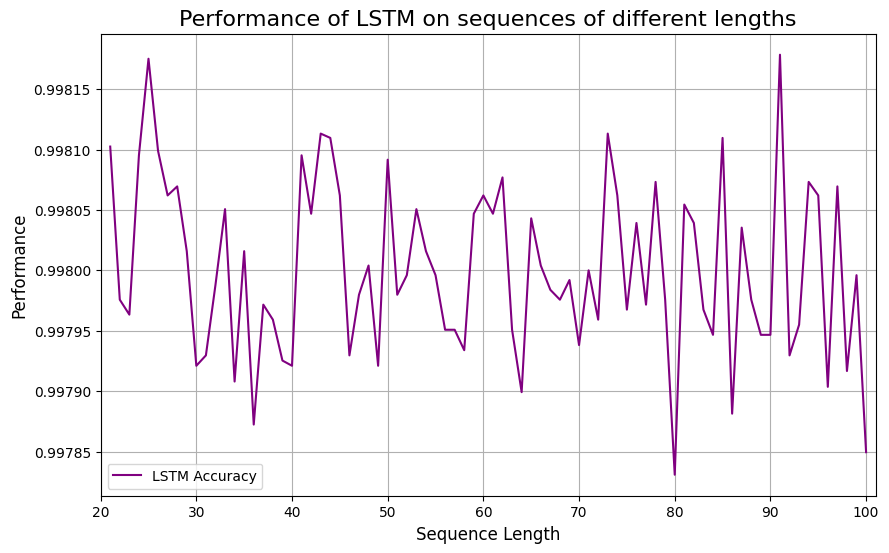

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(range(21, 101), accuracy_per_length, label='LSTM Accuracy', color='purple')
plt.xlim(20, 101)
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Performance', fontsize=12)
plt.title('Performance of LSTM on sequences of different lengths', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

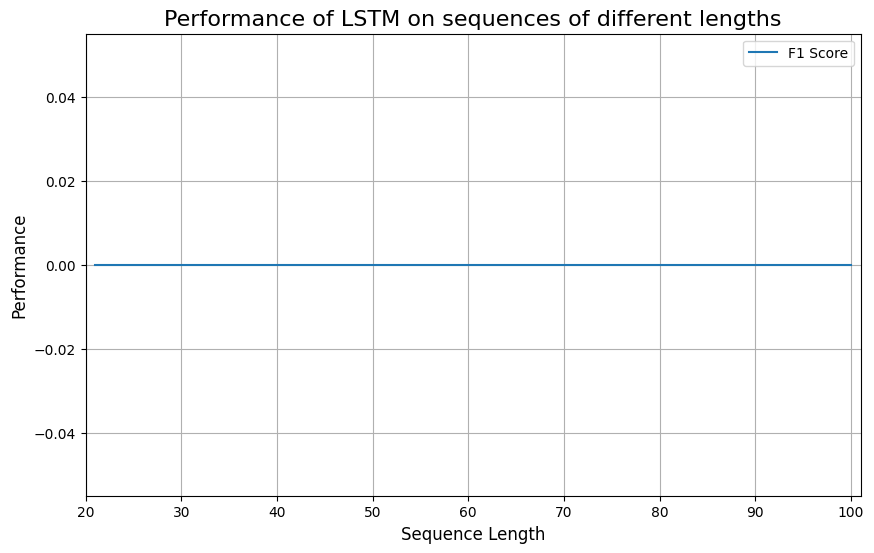

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(range(21, 101), f1_score_per_length, label='RNN F1 Score')
plt.xlim(20, 101)
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Performance', fontsize=12)
plt.title('Performance of LSTM on sequences of different lengths', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

## Plot results from LSTM and RNN

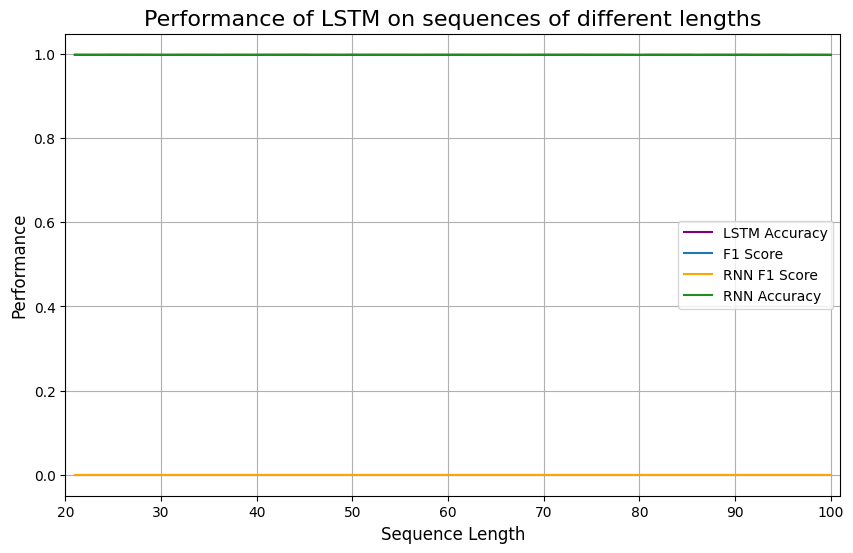

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(range(21, 101), accuracy_per_length, label='LSTM Accuracy', color='purple')
plt.plot(range(21, 101), f1_score_per_length, label='LSTM F1 Score')
plt.plot(range(21, 101), rnn_f1_score_per_length, label='RNN F1 Score', color='orange')
plt.plot(range(21, 101), rnn_accuracy_per_length, label='RNN Accuracy', color='forestgreen')
#plt.ylim(0.997, 1)
plt.xlim(20, 101)
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Performance', fontsize=12)
plt.title('Performance of LSTM on sequences of different lengths', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()